# Waveguide Dispersion

**Scott Prahl**

**27 Feb 2018, Version 2**

In [1]:
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

import ofiber as of

## Approximating Waveguide Dispersion

Waveguide dispersion $\Delta\tau_w$ is given by equation 10.11 

$$
\Delta\tau_w \approx - \frac{L}{c}n_2\Delta\frac{\Delta\lambda_0}{\lambda_0}\cdot\left(V\frac{d^2(bV)}{dV^2}\right)
$$

which is tough to calculate because of the presence of the normalized propagation factor $b$ which depends on solving the eigenvalue problem for the optical fiber.  However, once this has been done, someone noticed that  could be approximated by

$$
V\frac{d^2(bV)}{dV^2} \approx 0.080+0.549(2.834-V)^2
$$

How good is this approximation?

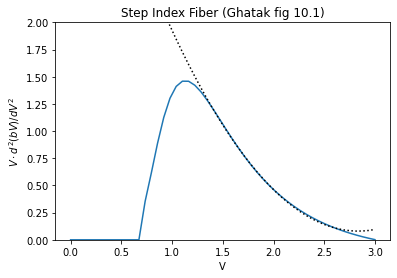

In [2]:
V    = np.linspace(0,3,50)
vbpp = of.V_d2bV_by_V(V,0)
vv   = of.V_d2bV_by_V_Approx(V)
    
plt.plot(V,vbpp)
plt.plot(V,vv,':k')
plt.xlabel('V')
plt.ylabel('$V\cdot d^2(bV)/dV^2$')
plt.title('Step Index Fiber (Ghatak fig 10.1)')
plt.ylim(0,2)
plt.show()

## Effect of GeO$_2$ on refractive index

Doping the core with GeO$_2$ changes the index of refraction

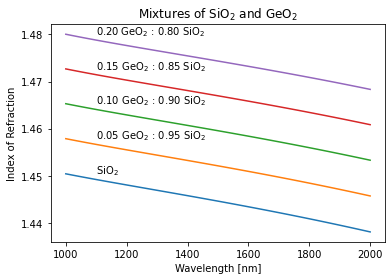

In [3]:
# Doping with GeO2 increases the index of refraction

lambda0 = np.linspace(1.0,2,50)*1e-6

for x in [0,0.05,0.1,0.15,0.2]:
    glass = of.doped_glass(x)
    name  = of.doped_glass_name(x)
    n     = of.n(glass,lambda0)
    plt.plot(lambda0*1e9,n)
    plt.annotate(name,xy=(1100,n[0]))

plt.xlabel("Wavelength [nm]")
plt.ylabel("Index of Refraction")
plt.title('Mixtures of SiO$_2$ and GeO$_2$')
plt.show()

# Conventional Single Mode Fiber

CSF has the characteristic that at 1300nm, the total dispersion is near zero.  Following example 10.1, we figure out that the amount of GeO$_2$ doping needed to match the indicies of refraction used in Ghatak's examples is about 2.6%.

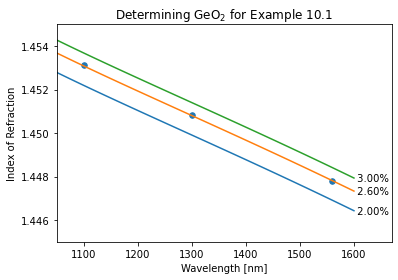

In [4]:
# Ghatak gives the core refractive index at three wavelengths
target  = np.array([1.45315, 1.45084, 1.44781])
lambda0 = np.array([   1100,    1300,    1560]) * 1e-9 # meters

n = of.n(glass,lambda0)
   
plt.scatter(lambda0*1e9,target,s=30)

lambdas = np.linspace(1000,1600,50)*1e-9
for x in [0.02,0.0260,0.03]:
    glass = of.doped_glass(x)
    n = of.n(glass,lambdas)
    plt.plot(lambdas*1e9,n)
    plt.text(1600,n[-1], " %.2f%%"%(100*x), va='center')

plt.xlabel('Wavelength [nm]')
plt.ylabel('Index of Refraction')
plt.xlim(1050,1670)
plt.ylim(1.445,1.455)
plt.title('Determining GeO$_2$ for Example 10.1')
plt.show()
   

Now that we know the doping fraction, we can calculate the dispersion for these fibers and thereby replicate table 10.2 that comes from example 10.1

In [5]:
a = 4.1e-6                                   # m
lambda0 = np.array([1100,1300,1560]) * 1e-9  # m

clad = of.doped_glass(0)
core = of.doped_glass(0.0260) # 2.6% GeO2, 97.4 SiO2

n_clad = of.n(clad,lambda0)
n_core = of.n(core,lambda0)

NA = of.numerical_aperture(n_core,n_clad)
V = of.v_parameter(a, NA, lambda0)

vbpp =of.V_d2bV_by_V_Approx(V)
dw = of.Waveguide_Dispersion(n_core,n_clad,a,lambda0) * 1e6
dm = of.Material_Dispersion(core,lambda0)* 1e6
dt = dm + dw

print('Ghatak Table 10.2')
print()
print("                  1100nm     1300nm     1560nm")
print("V                 %6.3f     %6.3f     %6.3f"%(V[0],V[1],V[2]))
print("V(bV)''           %6.3f     %6.3f     %6.3f"%(vbpp[0],vbpp[1],vbpp[2]))
print("D_w (ps/km/nm)    %6.2f     %6.2f     %6.2f"%(dw[0],dw[1],dw[2]))
print("D_m (ps/km/nm)    %6.2f     %6.2f     %6.2f"%(dm[0],dm[1],dm[2]))
print("D_t (ps/km/nm)    %6.2f     %6.2f     %6.2f"%(dt[0],dt[1],dt[2]))
print()
print('Small differences probably arise from slightly different index of refraction models for the core')

Ghatak Table 10.2

                  1100nm     1300nm     1560nm
V                  2.485      2.102      1.755
V(bV)''            0.147      0.374      0.719
D_w (ps/km/nm)     -1.83      -3.76      -5.96
D_m (ps/km/nm)    -23.14       1.38      21.45
D_t (ps/km/nm)    -24.97      -2.38      15.49

Small differences probably arise from slightly different index of refraction models for the core


### Contributions of waveguide and material dispersion to total dispersion

Here we see that zero total dispersion is around 1325nm

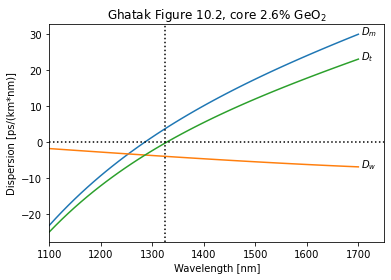

In [6]:
lambda0 = np.linspace(1100,1700,50)*1e-9   # m

n_clad = of.n(clad,lambda0)
n_core = of.n(core,lambda0)

dw = of.Waveguide_Dispersion(n_core,n_clad,a,lambda0) * 1e6          
dm = of.Material_Dispersion(core,lambda0)* 1e6
dt = dm + dw

plt.plot(lambda0*1e9,dm)
plt.text(1700, dm[-1], r' $D_m$')
                 
plt.plot(lambda0*1e9,dw)
plt.text(1700, dw[-1], r' $D_w$')

plt.plot(lambda0*1e9,dt)
plt.text(1700, dt[-1], r' $D_t$')

plt.axhline(0,   linestyle=':', color='black')
plt.axvline(1325,linestyle=':', color='black')

plt.xlabel("Wavelength [nm]")
plt.ylabel("Dispersion [ps/(km*nm)]")
plt.title('Ghatak Figure 10.2, core 2.6% GeO$_2$')
plt.xlim(1100,1750)
plt.show()

A close-up of the crossing range.

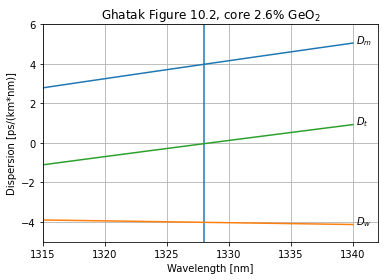

In [7]:
lambda0 = np.linspace(1315,1340,26)*1e-9   # m

n_clad = of.n(clad,lambda0)
n_core = of.n(core,lambda0)

dw = of.Waveguide_Dispersion(n_core,n_clad,a,lambda0) * 1e6          
dm = of.Material_Dispersion(core,lambda0)* 1e6
dt = dm + dw

izero = 13
plt.axvline(lambda0[izero]*1e9)

plt.plot(lambda0*1e9,dm)
plt.text(lambda0[-1]*1e9, dm[-1], ' $D_m$')

plt.plot(lambda0*1e9,dw)
plt.text(lambda0[-1]*1e9, dw[-1], ' $D_w$')

plt.plot(lambda0*1e9,dt)
plt.text(lambda0[-1]*1e9, dt[-1], ' $D_t$')

plt.xlabel("Wavelength [nm]")
plt.ylabel("Dispersion [ps/(km*nm)]")
plt.title('Ghatak Figure 10.2, core 2.6% GeO$_2$')
plt.xlim(1315,1342)
plt.ylim(-5,6)
plt.grid(True)
plt.show()

We can figure out the slope at the zero dispersion point.  

In [8]:
slope = (dt[izero+1]-dt[izero])/(lambda0[izero+1]-lambda0[izero]) #ps/km/nm * 1/m
slope *= 1e-9                                         #ps/km/nm**2
print('Zero dispersion slope is %.3f ps/(km nm**2)'%slope)

Zero dispersion slope is 0.081 ps/(km nm**2)


## Profile dispersion

First, we replicate the results in Ghatak example 10.2

In [9]:
a=4.1e-6                                 # [m]
lambda0=np.array([1100,1300,1560])*1e-9  # [m]

ncore = of.n(core,lambda0)
nclad = of.n(clad,lambda0)

Delta = (ncore**2-nclad**2)/(2*ncore**2)
dw = np.empty_like(lambda0)

for i in range(len(lambda0)):
    dw[i] = of.Waveguide_Dispersion(ncore[i],nclad[i],a,lambda0[i])*1e6
    
print("           1100nm     1300nm     1560nm")
print("n_core    %.5f    %.5f    %.5f"%(ncore[0],ncore[1],ncore[2]))
print("n_clad    %.5f    %.5f    %.5f"%(nclad[0],nclad[1],nclad[2]))
print("Delta     %.5f    %.5f    %.5f"%(Delta[0],Delta[1],Delta[2]))
print("D_w         %.2f      %.2f      %.2f"%(dw[0],dw[1],dw[2]))

           1100nm     1300nm     1560nm
n_core    1.45308    1.45080    1.44781
n_clad    1.44920    1.44692    1.44390
Delta     0.00267    0.00267    0.00270
D_w         -1.83      -3.76      -5.96


## Dispersion shifted fiber

This follows example 10.3.  First we need to figure out the appropriate doping that Ghatak used.  We match his core index value of 1.457893 at 1523nm.

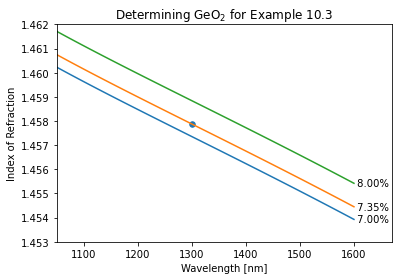

In [10]:
# estimation of doping of core for Ghatak Example 10.3

lambda0=np.array([1300])*1e-9
n = of.n(glass,lambda0)
target = np.array([1.457893])
   
plt.scatter(lambda0*1e9,target,s=30)

lambdas = np.linspace(1000,1600,50)*1e-9
for x in [0.07,0.0735,0.08]:
    glass = of.doped_glass(x)
    n = of.n(glass,lambdas)
    plt.plot(lambdas*1e9,n)
    plt.annotate(" %.2f%%"%(100*x),xy=(1600,n[-1]),va='center')

plt.ylim(1.453,1.462)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Index of Refraction')
plt.xlim(1050,1670)
plt.title('Determining GeO$_2$ for Example 10.3')
plt.show()
   

Now show the total dispersion is zero at the desired wavelength 1560nm.

In [11]:
a=2.3e-6                                 # [m]
lambda0=np.array([1100,1300,1560])*1e-9  # [m]

core = of.doped_glass(0.0735)
clad = of.doped_glass(0)

n_core = of.n(core,lambda0)
n_clad = of.n(clad,lambda0)

NA = of.numerical_aperture(n_core,n_clad)
V = of.v_parameter(a, NA, lambda0)

vbpp = of.V_d2bV_by_V(V,0)
dw = of.Waveguide_Dispersion(n_core,n_clad,a,lambda0) * 1e6          
dm = of.Material_Dispersion(core,lambda0)* 1e6
dt = dw + dm

print("Ghatak Table 10.3")
print()
print("                  1100nm     1300nm  1560nm")
print("Delta             %.4f    %.4f    %.4f"%(Delta[0],Delta[1],Delta[2]))
print("V                 %.3f     %.3f     %.3f"%(V[0],V[1],V[2]))
print("V(bV)''           %.3f     %.3f     %.3f"%(vbpp[0],vbpp[1],vbpp[2]))
print("D_w (ps/km/nm)    %.2f    %.2f    %.2f"%(dw[0],dw[1],dw[2]))
print("D_m (ps/km/nm)   %.2f     %.2f     %.2f"%(dm[0],dm[1],dm[2]))
print("D_t (ps/km/nm)   %.2f    %.2f     %.2f"%(dt[0],dt[1],dt[2]))

Ghatak Table 10.3

                  1100nm     1300nm  1560nm
Delta             0.0027    0.0027    0.0027
V                 2.344     1.983     1.656
V(bV)''           0.224     0.477     0.843
D_w (ps/km/nm)    -7.34    -13.27    -19.64
D_m (ps/km/nm)   -25.81     -0.65     19.69
D_t (ps/km/nm)   -33.15    -13.91     0.05


## Dispersion Compensating Fibers

To match example 10.4, once again we need to determine the doping to reach n=1.476754 at 1300nm.

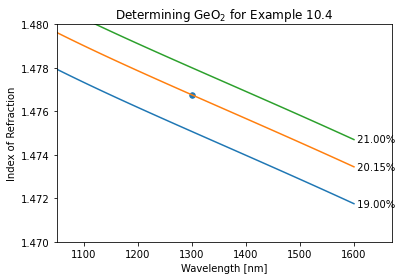

In [12]:
# estimation of doping of core for Ghatak Example 10.4

lambda0=np.array([1300])*1e-9
n = of.n(glass,lambda0)
target = np.array([1.476754])
   
plt.scatter(lambda0*1e9,target,s=30)

lambda00 = np.linspace(1000,1600,50)*1e-9
for x in [0.19,0.2015,0.21]:
    glass = of.doped_glass(x)
    n = of.n(glass,lambda00)
    plt.plot(lambda00*1e9,n)
    plt.annotate(" %.2f%%"%(100*x),xy=(1600,n[-1]),va='center')

plt.ylim(1.47,1.48)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Index of Refraction')
plt.xlim(1050,1670)
plt.title('Determining GeO$_2$ for Example 10.4')
plt.show()
   

Now calculate the dispersion at each wavelength.  Despite getting the correct values for the relative refractive index $\Delta$ and $V$, the dispersion values are off by about a factor of two from those cited on page 191.  Don't really understand why. 

I suspect that the graph used a different doping concentration and that the value of $n_14 listed in equation 10.22 is wrong.

In [13]:
a=1.5e-6                                 # [m]
lambda0=np.array([1100,1300,1560])*1e-9  # [m]

core = of.doped_glass(0.2015)
clad = of.doped_glass(0.00)

n_core = of.n(core,lambda0)
n_clad = of.n(clad,lambda0)
Delta = (n_core**2-n_clad**2)/(2*n_core**2)

NA = of.numerical_aperture(n_core,n_clad)
V = of.v_parameter(a, NA, lambda0)
VV = 2783.6/lambda0*1e-9

dm = of.Material_Dispersion(core,lambda0)* 1e6
dw = of.Waveguide_Dispersion(n_core,n_clad,a,lambda0) * 1e6          
dt = dm+dw

print("                 1100nm     1300nm     1560nm")
print("n_core          %.5f    %.5f    %.5f"%(n_core[0],n_core[1],n_core[2]))
print("n_clad          %.5f    %.5f    %.5f"%(n_clad[0],n_clad[1],n_clad[2]))
print("Delta           %.5f    %.5f    %.5f"%(Delta[0],Delta[1],Delta[2]))
print()

print("V                 %.3f      %.3f      %.3f"%(V[0],V[1],V[2]))
print("2783.6/lambda0    %.3f      %.3f      %.3f"%(VV[0],VV[1],VV[2]))
print()

print("D_w (ps/km/nm)   %.2f     %.2f     %.2f"%(dw[0],dw[1],dw[2]))
print("D_m (ps/km/nm)   %.2f      %.2f      %.2f"%(dm[0],dm[1],dm[2]))
print("D_t (ps/km/nm)   %.2f     %.2f     %.2f"%(dt[0],dt[1],dt[2]))
print()
print("Which are about half the values given on page 191 of Ghatak ...")

                 1100nm     1300nm     1560nm
n_core          1.47901    1.47676    1.47390
n_clad          1.44920    1.44692    1.44390
Delta           0.01995    0.02000    0.02014

V                 2.531      2.141      1.787
2783.6/lambda0    2.531      2.141      1.784

D_w (ps/km/nm)   -11.98     -25.96     -42.20
D_m (ps/km/nm)   -33.24      -6.16      15.03
D_t (ps/km/nm)   -45.22     -32.12     -27.17

Which are about half the values given on page 191 of Ghatak ...


## Comparison of DCF, DSF, and CSF fiber dispersion

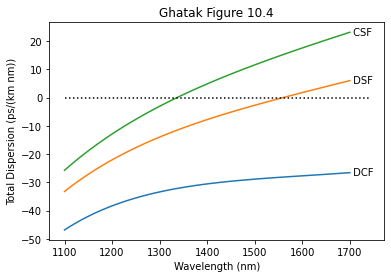

In [14]:
# Demonstration of Profile Dispersion, Ghatak example 10.4

a=1.5e-6                                 # [m]
lambda0=np.linspace(1100,1700,100)*1e-9  # [m]
dt = np.empty_like(lambda0)


# Dispersion Compensating Fiber
core = of.doped_glass(0.2205)
clad = of.doped_glass(0.02)
ncore = of.n(core,lambda0)
nclad = of.n(clad,lambda0)
Delta = (ncore**2-nclad**2)/(2*ncore**2)
for i in range(len(lambda0)):
    dt[i] = of.Total_Dispersion(core,Delta[i],a,lambda0[i])*1e6
plt.plot(lambda0*1e9,dt)
plt.annotate(' DCF',xy=(1700,dt[-1]),va='center')

# Dispersion Shifted Fiber
a=2.3e-6
core = of.doped_glass(0.0735)
clad = of.doped_glass(0.0)
ncore = of.n(core,lambda0)
nclad = of.n(clad,lambda0)
Delta = (ncore**2-nclad**2)/(2*ncore**2)
for i in range(len(lambda0)):
    dt[i] = of.Total_Dispersion(core,Delta[i],a,lambda0[i])*1e6
plt.plot(lambda0*1e9,dt)
plt.annotate(' DSF',xy=(1700,dt[-1]),va='center')


# Dispersion Compensated Fiber
a=4.1e-6
core = of.doped_glass(0.0201)
clad = of.doped_glass(0.0)
ncore = of.n(core,lambda0)
nclad = of.n(clad,lambda0)
Delta = (ncore**2-nclad**2)/(2*ncore**2)
for i in range(len(lambda0)):
    dt[i] = of.Total_Dispersion(core,Delta[i],a,lambda0[i])*1e6
plt.plot(lambda0*1e9,dt)
plt.annotate(' CSF',xy=(1700,dt[-1]),va='center')

plt.plot([1100,1740],[0,0],':k')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Total Dispersion (ps/(km nm))")
plt.title('Ghatak Figure 10.4')
plt.show()

## Single mode operation region

It depends on $\Delta$, the fiber radius, and the wavelength.  Figure 10.5

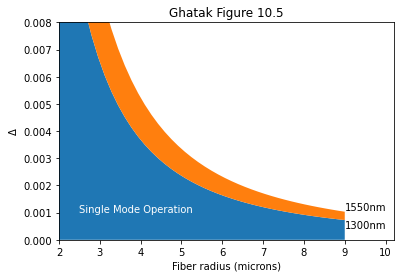

In [15]:
a=np.linspace(1,9,50)*1e-6

n1=1.45
Vc = 2.4048
lambda0 = 1300e-9
coef = Vc/2/np.pi/n1
Delta1 = 0.5*(coef * lambda0/a)**2
plt.fill_between(a*1e6,0,Delta1)
plt.annotate('1300nm',xy=(9,Delta1[-1]),va='top')


lambda0 = 1550e-9
Delta = 0.5*(coef * lambda0/a)**2
#plt.plot(a*1e6,Delta)
plt.fill_between(a*1e6, Delta1, Delta)
plt.annotate('1550nm',xy=(9,Delta[-1]),va='bottom')
plt.xlabel('Fiber radius (microns)')
plt.ylabel(r'$\Delta$')
plt.title('Ghatak Figure 10.5')
plt.ylim(0,0.008)
plt.xlim(2,10.2)
plt.annotate('Single Mode Operation', xy=(2.5,0.001),color='white')
plt.show()


## Petermann-2 spot size

The recommendation is that the Petermann-2 spot size for a single-mode fiber should be limited to 4.5 to 5 microns. This really restricts the possible values for $a$ and $\Delta$ for single mode fibers.

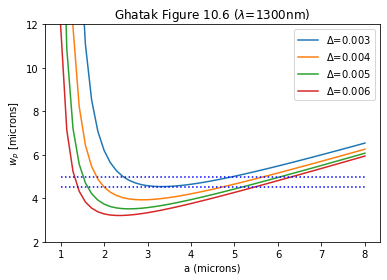

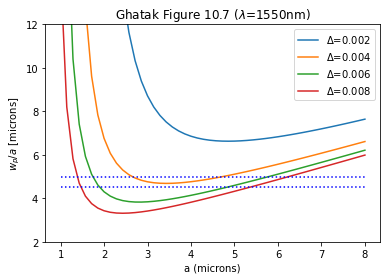

In [16]:
a=np.linspace(1,8,50)*1e-6

n1=1.45
lambda0 = 1300e-9

for i in range(3,7):
    Delta = i * 0.001
    V = (2*np.pi/lambda0) * a * n1 * np.sqrt(2*Delta)
    wp = of.PetermannW(V)*a
    plt.plot(a*1e6,wp*1e6,label=r'$\Delta$=%.3f'%Delta)

plt.xlabel('a (microns)')
plt.ylabel('$w_p$ [microns]')
plt.title('Ghatak Figure 10.6 ($\lambda$=1300nm)')
plt.ylim(2,12)
plt.plot([1,8],[4.5,4.5],':b')
plt.plot([1,8],[5,5],':b')

plt.legend()
plt.show()

a=np.linspace(1,8,50)*1e-6

n1=1.45
lambda0 = 1550e-9

for i in range(1,5):
    Delta = i * 0.002
    V = (2*np.pi/lambda0) * a * n1 * np.sqrt(2*Delta)
    wp = of.PetermannW(V)*a
    plt.plot(a*1e6,wp*1e6,label=r'$\Delta$=%.3f'%Delta)

plt.xlabel('a (microns)')
plt.ylabel('$w_p/a$ [microns]')
plt.title('Ghatak Figure 10.7 ($\lambda$=1550nm)')
plt.ylim(2,12)
plt.plot([1,8],[4.5,4.5],':b')
plt.plot([1,8],[5,5],':b')

plt.legend()
plt.show()

## Bending loss

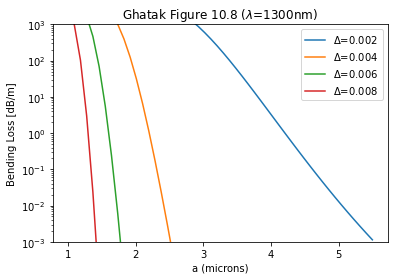

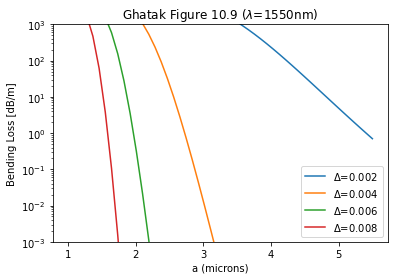

In [17]:
a=np.linspace(1,5.5,50)*1e-6

n1=1.45
lambda0 = 1300e-9    # [m]
Rc = 3.75e-2         # 3.75cm

for i in range(1,5):
    Delta = i * 0.002
    alpha = of.Bending_loss_db(n1, Delta, a, Rc, lambda0)
    plt.semilogy(a*1e6,alpha,label=r'$\Delta$=%.3f'%Delta)

plt.xlabel('a (microns)')
plt.ylabel('Bending Loss [dB/m]')
plt.title('Ghatak Figure 10.8 ($\lambda$=1300nm)')
plt.ylim(1e-3,1e3)
plt.legend()
plt.show()

a=np.linspace(1,5.5,50)*1e-6

n1=1.45
lambda0 = 1550e-9    # [m]
Rc = 3.75e-2         # 3.75cm

for i in range(1,5):
    Delta = i * 0.002
    alpha = of.Bending_loss_db(n1, Delta, a, Rc, lambda0)
    plt.semilogy(a*1e6,alpha,label=r'$\Delta$=%.3f'%Delta)

plt.xlabel('a (microns)')
plt.ylabel('Bending Loss [dB/m]')
plt.title('Ghatak Figure 10.9 ($\lambda$=1550nm)')
plt.ylim(1e-3,1e3)
plt.legend()
plt.show()